In [1]:
from langchain import OpenAI
from langchain.agents import Tool, tool
from langchain import agents
import langchain
import os
import warnings
import numpy as np
warnings.filterwarnings('ignore')
import sys
import dziner


# from langchain.chains import RetrievalQA
from langchain.document_loaders import PyPDFLoader
from langchain_openai import ChatOpenAI

from langchain.vectorstores import FAISS
from langchain.embeddings.openai import OpenAIEmbeddings
Embedding_model = 'text-embedding-3-large' 

from langchain.text_splitter import CharacterTextSplitter

In [2]:
## This model based on this paper: https://pubs.acs.org/doi/abs/10.1021/acs.jpcb.1c05264
## And is coming from this URL 
## https://github.com/zavalab/ML/blob/master/CMC_GCN/saved_models/gnn_logs_save_202_hu256_lr0.005_best_trainalles_seed4592/ep200bs5lr0.005hu256es.pth.tar

import torch
from dziner.surrogates.CMC.model import predict_single_point

@tool
def predict_cmc(smiles):
    '''
    This tool predicts the log Critical Micelle Concentration (CMC) for a SMILES. The model is based on a GCN from this paper:
    https://pubs.acs.org/doi/abs/10.1021/acs.jpcb.1c05264
    '''
    model_path = r"../dziner/surrogates/CMC/ep200bs5lr0.005hu256es.pth.tar"  # Path to the model checkpoint
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    try:
        infered_cmc = predict_single_point(smiles, model_path, device)
        return np.round(infered_cmc,3)
        
    except:
        infered_cmc = None
        return 'Invalid molecule'

predict_cmc('CCCCCOCCO')

3.716

In [3]:
from langchain.memory import ConversationBufferMemory

RetrievalQA_prompt = """What are the design guidelines for making the surfactant with a Critical Micelle Concentration? 
    This can be based on making changes to the functional groups or other changes to the molecule. Summarize your answer and cite paper
    by the title, DOI and the journal and year the document was published on."""

@tool
def lookup_papers(prompt):
    '''Useful for getting chemical intuition for the problem.
    This tool looks up design guidelines for molecules with lower Critical Micelle Concentration by looking through research papers.
    It also includes information on the paper citation or DOI.
    '''
    guide_lines = []
    for m in range(3):
        text_splitter = CharacterTextSplitter(
            chunk_size=500, chunk_overlap=20)
        paper_file =f'../data/papers/CMC/{m}.pdf'
        pages = PyPDFLoader(paper_file).load_and_split()
        sliced_pages = text_splitter.split_documents(pages)
        faiss_vectorstore = FAISS.from_documents(sliced_pages, OpenAIEmbeddings(model=Embedding_model))
        
        llm=ChatOpenAI(
                        model_name='gpt-4o',
                        temperature=0.1,
                        )
        g = dziner.RetrievalQABypassTokenLimit(faiss_vectorstore, RetrievalQA_prompt, llm)
        guide_lines.append(g)
        # break
    return " ".join(guide_lines)

# guidel_lines = lookup_papers("")
# guidel_lines

In [4]:

@tool
def check_validity(SMILES):
    '''This tool inputs SMILES string representations checks if it is a chemically feasible molecule.
    '''
    from rdkit import Chem
    from rdkit.Chem import Draw
    try:
        mol = Chem.MolFromSmiles(SMILES)
        if mol is None:
            return "Invalid", SMILES
        return "Valid", SMILES
    except Exception as e:
        # return f"An error occurred: {str(e)}"
        return "Invalid ", SMILES

tools = [lookup_papers, check_validity, predict_cmc]

tool_names = [tool.name for tool in tools]  
tool_desc = [tool.description for tool in tools]

initial_surfactant = "CCCCCOCCO" 
Human_prompt = f"Make changes to {initial_surfactant} so it will have a lower Critical Micelle Concentration (CMC)"

input_data = {
            "input": Human_prompt,
            "prompt": RetrievalQA_prompt,
            "tools": tools,
            "tool_names": tool_names,
            "tool_desc": tool_desc
        }

In [124]:
suffix = """Lookup and summarize design guidelines. Make sure to add citations (paper DOI) for design guidelines if you use them, in your final response.
    Your final response should also contain the source for the tools used from their summary in description in {tool_desc}.
    Always evaluate the Critical Micelle Concentration (CMC) and then validity of the first input SMILES first.
    After each change you should calculate the Critical Micelle Concentration (CMC) and ALWAYS evaluate the validity of the new molecule.
    If the molecule is invalid, revert change to the previous valid SMILES and try something else and re-evaluate validity.
    Do not use "\n" after the SMILES.
    Iterate for a total of 10 new molecule candidates and then stop. 
    Each iteration ends after you have checked the validity of the molecule.
    When you have a response to say to the Human, or if you do not need to use a tool, you MUST use the format:
    '''
    Thought: Here's your final answer:
    Final Answer: [your response here]
    '''
    Start by describing the problem: \n\nBegin!\n \n\nQuestion: {input}
Thought:{agent_scratchpad}\n"""


prefix = """You are a helpful Chemist AI assistant called dZiner. You are tasked to make changes to a molecule based on some design guidelines
    and optimize the molecule's property.
    Always use the tools to get chemical intuition learn about the design guidelines. If you don't know, do not make up answers.
    Explain changes you make in details at each step but do not put redundant information.
    """
    

# FORMAT_INSTRUCTIONS = """
#     When responding, please output a response in this format only:
    
#     json code snippet formatted in the following schema:
    
#     ```json
#     {{"action": string, # The action to take. Must be one of {tool_names}
#         "action_input": string # The input to the action}}
#     ```
    
#     Make sure "Action:" comes after "Thought". You have access to the following tools: 
#     {tool_names}
#     Use the exact SMILES without any "\n" or any extra "()".

#     When you have a response to say to the Human, or if you do not need to use a tool, you MUST use the format:
#     '''
#     Thought: Here's your final answer:
#     Final Answer: [your response here]
#     '''
    
#     """
FORMAT_INSTRUCTIONS = """Use the following format:

Question: the input question you must answer
Thought: you should always think about what to do
Action: the action to take, should be one of [{tool_names}]
Action Input: the input to the action
Observation: the result of the action
... (this Thought/Action/Action Input/Observation can repeat N times)
When you have a response to say to the Human, or if you do not need to use a tool, you MUST use the format:
'''
Thought: Here's your final answer:
Final Answer: [your response here]
'''

Use the exact SMILES without any "\n" or any extra "()".
"""

suffix = """You should always follow these steps:
    1. Lookup and summarize design guidelines. Make sure to add citations (paper DOI) for design guidelines if you use them, in your final response.
    Your final response should also contain the source for the tools used from their summary in description in {tool_desc}.
    2. Evaluate the Critical Micelle Concentration (CMC) of the initial molecule.
    3. Evaluate the validity of the initial molecule.
    4. Start making changes to the molecule based on guidelines you found in step 1. Try to use different changes at each iteration.
    5. Evaluate the Critical Micelle Concentration (CMC) for the new molecule
    6. Evaluate validity of the SMILES for the new molecule
    7. If the Critical Micelle Concentration (CMC) does not change properly, still evaluate validity and if the
    molecule is invalid, revert change to the previous valid SMILES and try something else by
    redoing steps 4-7. Iterate until there are 10 new SMILES candidates and then stop.

    Start by describing the problem: \n\nBegin!\n \n\nQuestion: {input}
Thought:{agent_scratchpad}\n"""

In [125]:
import langchain
from langchain.agents import initialize_agent
from langchain.memory import ConversationBufferMemory
from langchain.callbacks import get_openai_callback
from langchain.agents import AgentType
from langchain_core.prompts import MessagesPlaceholder
from langchain_openai import ChatOpenAI
# from .prompts import prefix, suffix


class dZiner:
    def __init__(
        self,
        tools,
        property,
        model="text-davinci-003",
        temp=0.1,
        get_cost=False,
        max_iterations=40,
        agent_type=AgentType.CONVERSATIONAL_REACT_DESCRIPTION,
        n_design_iterations=1,
        **kwargs
    ):
        self.property = property
        self.n_design_iterations = n_design_iterations
        # keeping the variables the same so they are updated later in langchain.
        formatted_suffix = suffix.format(property=self.property,
                                         tool_desc="{tool_desc}",
                                        input="{input}",
                                        agent_scratchpad="{agent_scratchpad}",
                                        n_design_iterations=self.n_design_iterations)
        # formatted_prefix = prefix.format(property=self.property,
        #                                  tool_names="{tool_names}")
        self.suffix = kwargs.get('suffix', formatted_suffix)        
        format_instructions = kwargs.get('format_instructions', FORMAT_INSTRUCTIONS)
        self.format_instructions = format_instructions#  format_instructions.format(tool_names="{tool_names}")
        # print(self.format_instructions)
        
        self.prefix = kwargs.get('prefix', prefix)

        self.model = model
        if model.startswith("gpt-3.5-turbo") or model.startswith("gpt-4"):
            self.model = ChatOpenAI(
                temperature=temp,
                model_name=model,
                request_timeout=1000,
                max_tokens=4096,
            )
        self.get_cost = get_cost
        self.max_iterations = max_iterations

        # Initialize agent
        memory = ConversationBufferMemory(
            memory_key="chat_history",
            input_key='input',
            output_key="output",
            return_messages=True
        )

        self.verbose = kwargs.get('verbose', False)
        chat_history = MessagesPlaceholder(variable_name="chat_history")
        self.agent = initialize_agent(
            tools=tools,
            llm=self.model,
            agent_type=agent_type,
            verbose=self.verbose,
            memory=memory,
            early_stopping_method='generate',
            handle_parsing_errors=True,
            agent_kwargs={
                "prefix": self.prefix,
                "suffix": self.suffix,
                "memory_prompts": [chat_history],
                'format_instructions':  self.format_instructions,
                "input_variables": [
                    "input",
                    "agent_scratchpad",
                    "chat_history"
                ],
            },
            return_intermediate_steps=True,
            max_iterations=max_iterations
        )

    def __call__(self, prompt):
        with get_openai_callback() as cb:
            result = self.agent.invoke({"input":prompt})
        if self.get_cost:
            print(cb)
        return result

In [126]:
FORMAT_INSTRUCTIONS.format(tool_names="{tool_names}")

'Use the following format:\n\nQuestion: the input question you must answer\nThought: you should always think about what to do\nAction: the action to take, should be one of [{tool_names}]\nAction Input: the input to the action\nObservation: the result of the action\n... (this Thought/Action/Action Input/Observation can repeat N times)\nWhen you have a response to say to the Human, or if you do not need to use a tool, you MUST use the format:\n\'\'\'\nThought: Here\'s your final answer:\nFinal Answer: [your response here]\n\'\'\'\n\nUse the exact SMILES without any "\n" or any extra "()".\n'

In [127]:
# from dziner.agents import dZiner
agent = dZiner(tools, property="Critical Micelle Concentration (CMC)",
               model='gpt-4o', verbose=True, n_design_iterations=10, temp=0.1,
              suffix=suffix, prefix=prefix, format_instructions=FORMAT_INSTRUCTIONS).agent

agent.get_prompts

<bound method Runnable.get_prompts of AgentExecutor(memory=ConversationBufferMemory(output_key='output', input_key='input', return_messages=True, memory_key='chat_history'), verbose=True, tags=['zero-shot-react-description'], agent=ZeroShotAgent(llm_chain=LLMChain(prompt=PromptTemplate(input_variables=['agent_scratchpad', 'input', 'tool_desc'], template='You are a helpful Chemist AI assistant called dZiner. You are tasked to make changes to a molecule based on some design guidelines\n    and optimize the molecule\'s property.\n    Always use the tools to get chemical intuition learn about the design guidelines. If you don\'t know, do not make up answers.\n    Explain changes you make in details at each step but do not put redundant information.\n    \n\nlookup_papers: lookup_papers(prompt) - Useful for getting chemical intuition for the problem.\n    This tool looks up design guidelines for molecules with lower Critical Micelle Concentration by looking through research papers.\n    It 

In [128]:
# response = agent_executor.invoke({"input": f"Look up design guidelines and make changes to the MOF [Co].[O-]C(=O)c1ccncc1 so it will have a higher band gap:\
#             After each change you should first check validity of new SMILES, if valid evaluate the band gap, otherwise revert change and try something else.\n\
#             "})

In [129]:
# Initialize iteration variables
iteration_data = []
iteration = 0
cost = 0
from langchain_community.callbacks import get_openai_callback


for step in agent.iter(input_data):
    with get_openai_callback() as cb:
        if output := step.get("intermediate_step"):
            action, value = output[0]
            if action.tool == "predict_cmc":
                current_cmc = value  # Capture the predicted CMC value
            elif action.tool == "check_validity":
                current_feasibility, current_smiles = value
                current_smiles = current_smiles.strip()  # Remove any trailing newline characters
                iteration_data.append({
                        'iteration': iteration,
                        'data': {
                            'SMILES': current_smiles,
                            'Chemical Feasibility': current_feasibility,
                            'CMC': current_cmc,
                        }
                    })
                iteration += 1
        # elif step.get("Observation") == 'Invalid molecule':
        #     # Handle invalid molecule case
        #     iteration_data.append({
        #         'iteration': iteration,
        #         'data': {
        #             'SMILES': "Invalid",
        #             'Chemical Feasibility': "Invalid",
        #             'CMC': infered_cmc,
        #         }
        #     })
        #     iteration += 1
    cost += cb.total_cost





> Entering new AgentExecutor chain...
To begin, I need to gather design guidelines for molecules with lower Critical Micelle Concentration (CMC). This will help me understand the structural features that can influence CMC and guide the modifications I make to the initial molecule, CCCCCOCCO.

Action: lookup_papers
Action Input: Design guidelines for molecules with lower Critical Micelle Concentration (CMC)
Observation: The design guidelines for making surfactants with a low Critical Micelle Concentration (cmc) involve several key considerations related to the molecular structure, particularly the hydrophobic tails and headgroups. Here are the summarized guidelines:

1. **Hydrophobic Tail Structure**:
   - **Chain Length**: Increasing the length of the hydrophobic tail generally decreases the cmc. This is described by the Klevens equation, where the cmc decreases logarithmically with the length of the alkyl chain.
   - **Branching**: Introducing branching in the hydrophobic tail, espe

In [130]:
iteration_data

[{'iteration': 0,
  'data': {'SMILES': 'CCCCCOCCO',
   'Chemical Feasibility': 'Valid',
   'CMC': 3.716}},
 {'iteration': 1,
  'data': {'SMILES': 'CCCCCCCCOCCO',
   'Chemical Feasibility': 'Valid',
   'CMC': 3.173}},
 {'iteration': 2,
  'data': {'SMILES': 'CCC(C)CCCCOCCO',
   'Chemical Feasibility': 'Valid',
   'CMC': 3.906}},
 {'iteration': 3,
  'data': {'SMILES': 'CCCCCCC(CF)OCCO',
   'Chemical Feasibility': 'Valid',
   'CMC': 3.274}},
 {'iteration': 4,
  'data': {'SMILES': 'CCCCCCCCCCCOCCO',
   'Chemical Feasibility': 'Valid',
   'CMC': 1.198}},
 {'iteration': 5,
  'data': {'SMILES': 'CCC(C)CCCCCCCOCCO',
   'Chemical Feasibility': 'Valid',
   'CMC': 2.946}},
 {'iteration': 6,
  'data': {'SMILES': 'CCCCCCCCCC(CF)OCCO',
   'Chemical Feasibility': 'Valid',
   'CMC': 1.903}},
 {'iteration': 7,
  'data': {'SMILES': 'CCCCCCCC(C)CCOCCO',
   'Chemical Feasibility': 'Valid',
   'CMC': 3.458}}]

In [114]:
initial_surfactant = "CCCCCOCCO" 
# question = f"Look up design guidelines and make changes to {initial_surfactant} so it will have a lower Critical Micelle Concentration (CMC):\
#             Alway evaluate the CMC and then validity of the input SMILES first\
#              After each change you should calculate the logCMC predicted value and evaluate the the validity of the new molecule. \
#             if invalid revert change to the previous valid SMILES and try something else and re-evauate validity.\
#             Do not make changes involving Fluorine.\
#              Iterate for 10 new molecule candidates and then stop.\n\
#              "
iteration_data = []
iteration = 0
cost = 0
from langchain_community.callbacks import get_openai_callback


for step in agent.iter(input_data):
    with get_openai_callback() as cb:
        if output := step.get("intermediate_step"):
            action, value = output[0]
            if action.tool == "predict_cmc":
                infered_cmc = value
            elif action.tool == "check_validity":
                chemical_feasibility, SMILES = value
                # Remove any trailing newline characters
                SMILES = SMILES.strip()
                iteration_data.append({
                                        'iteration': iteration,
                                        'data': {
                                            'SMILES': SMILES,
                                            'Chemical Feasibility': chemical_feasibility,
                                            'CMC': infered_cmc,
                                        }
                                    })
                iteration += 1
            elif step.get("Observation") == 'Invalid molecule':
                # Handle invalid molecule case
                iteration_data.append({
                    'iteration': iteration,
                    'data': {
                        'SMILES': "Invalid",
                        'Chemical Feasibility': "Invalid",
                        'CMC': infered_cmc,
                    }
                })
                iteration += 1
            
                # break 
                # assert is_prime(int(value))
            # Ask user if they want to continue
            # _continue = input("Should the agent continue (Y/n)?:\n") or "Y"
            # if _continue.lower() != "y":
            #     break
    cost += cb.total_cost

print(f'Cost: ${cost}')



> Entering new AgentExecutor chain...
To begin, I need to gather design guidelines for molecules with lower Critical Micelle Concentration (CMC). This will help me understand the structural modifications that can be made to achieve the desired property.

Action: lookup_papers
Action Input: Design guidelines for molecules with lower Critical Micelle Concentration (CMC)

KeyboardInterrupt: 

In [113]:
iteration_data

[{'iteration': 0,
  'data': {'SMILES': 'CCCCCOCCO',
   'Chemical Feasibility': 'Valid',
   'CMC': 3.716}},
 {'iteration': 1,
  'data': {'SMILES': 'CCCCCCCOCCO',
   'Chemical Feasibility': 'Valid',
   'CMC': 3.497}},
 {'iteration': 2,
  'data': {'SMILES': 'CCC(C)CCCCOCCO',
   'Chemical Feasibility': 'Valid',
   'CMC': 3.906}},
 {'iteration': 3,
  'data': {'SMILES': 'CCCCCCCOCC(O)CO',
   'Chemical Feasibility': 'Valid',
   'CMC': 3.642}},
 {'iteration': 4,
  'data': {'SMILES': 'CCCCCCC(F)OCCO',
   'Chemical Feasibility': 'Valid',
   'CMC': 3.351}}]

In [18]:
# # Initialize dZiner agent
# agent = dZiner(
#     tools, 
#     property="Critical Micelle Concentration (CMC)",
#     model='gpt-4o-2024-05-13', 
#     verbose=True, 
#     n_design_iterations=5, 
#     temp=0.05, 
#     suffix=suffix
# ).agent

# # Initial surfactant
# initial_surfactant = "CCCCCOCCO"

# # Initialize iteration variables
# iteration_data = []
# iteration = 0
# cost = 0

# # Start the agent iteration
# for step in agent.iter(input_data):
#     with get_openai_callback() as cb:
#         if output := step.get("intermediate_step"):
#             action, value = output[0]
#             if action.tool == "predict_cmc":
#                 infered_cmc = value
#             elif action.tool == "check_validity":
#                 chemical_feasibility, SMILES = value
#                 iteration_data.append({
#                     'iteration': iteration,
#                     'data': {
#                         'SMILES': SMILES,
#                         'Chemical Feasibility': chemical_feasibility,
#                         'CMC': infered_cmc,
#                     }
#                 })
#                 iteration += 1
#         elif step.get("Observation") == 'Invalid molecule':
#             iteration_data.append({
#                 'iteration': iteration,
#                 'data': {
#                     'SMILES': "Invalid",
#                     'Chemical Feasibility': "Invalid",
#                     'CMC': infered_cmc,
#                 }
#             })
#             iteration += 1




> Entering new AgentExecutor chain...
To optimize the molecule CCCCCOCCO for a lower Critical Micelle Concentration (CMC), I will first evaluate its current CMC and validity. Then, I will look up design guidelines for lowering CMC and make iterative changes to the molecule, checking each new structure for validity and CMC.

Let's start by evaluating the CMC and validity of the initial molecule.

Action: predict_cmc
Action Input: CCCCCOCCO
Observation: 3.716
Thought:The initial molecule CCCCCOCCO has a predicted log CMC of 3.716. Now, let's check the validity of this molecule.

Action: check_validity
Action Input: CCCCCOCCO
Observation: ('Valid', 'CCCCCOCCO')
Thought:The initial molecule CCCCCOCCO is valid and has a predicted log CMC of 3.716. To proceed, I will look up design guidelines for lowering the CMC of molecules.

Action: lookup_papers
Action Input: design guidelines for lowering Critical Micelle Concentration (CMC)
Observation: To design surfactants with an optimal Critical 

In [24]:
iteration_data

[{'iteration': 0,
  'data': {'SMILES': 'CCCCCOCCO\n',
   'Chemical Feasibility': 'Valid',
   'CMC': 3.716}},
 {'iteration': 1,
  'data': {'SMILES': 'CCCCCCCCOCCO\n',
   'Chemical Feasibility': 'Valid',
   'CMC': 3.716}},
 {'iteration': 2,
  'data': {'SMILES': 'CC(C)CCCCCOCCO\n',
   'Chemical Feasibility': 'Valid',
   'CMC': 3.173}},
 {'iteration': 3,
  'data': {'SMILES': 'CCCCCCCCFCCO\n',
   'Chemical Feasibility': 'Invalid',
   'CMC': 3.68}},
 {'iteration': 4,
  'data': {'SMILES': 'CCCCCCCCO[Si](C)C\n',
   'Chemical Feasibility': 'Valid',
   'CMC': 3.68}},
 {'iteration': 5,
  'data': {'SMILES': 'CCCCCCCC(C)OCCO\n',
   'Chemical Feasibility': 'Valid',
   'CMC': 3.711}},
 {'iteration': 6,
  'data': {'SMILES': 'CC(C)CCCCCC(C)OCCO\n',
   'Chemical Feasibility': 'Valid',
   'CMC': 3.05}},
 {'iteration': 7,
  'data': {'SMILES': 'CCCCCCCC(C)OCC(O)CO\n',
   'Chemical Feasibility': 'Valid',
   'CMC': 3.449}}]

In [25]:
import json
json_data = json.dumps(iteration_data, indent=4)
# Save the JSON data to a file
with open(f"../results/CMC/{iteration_data[0]['data']['SMILES']}_guided.json", "w") as json_file:
    json_file.write(json_data)

Text(0, 0.5, 'logCMC (μM)')

<Figure size 2560x1920 with 0 Axes>

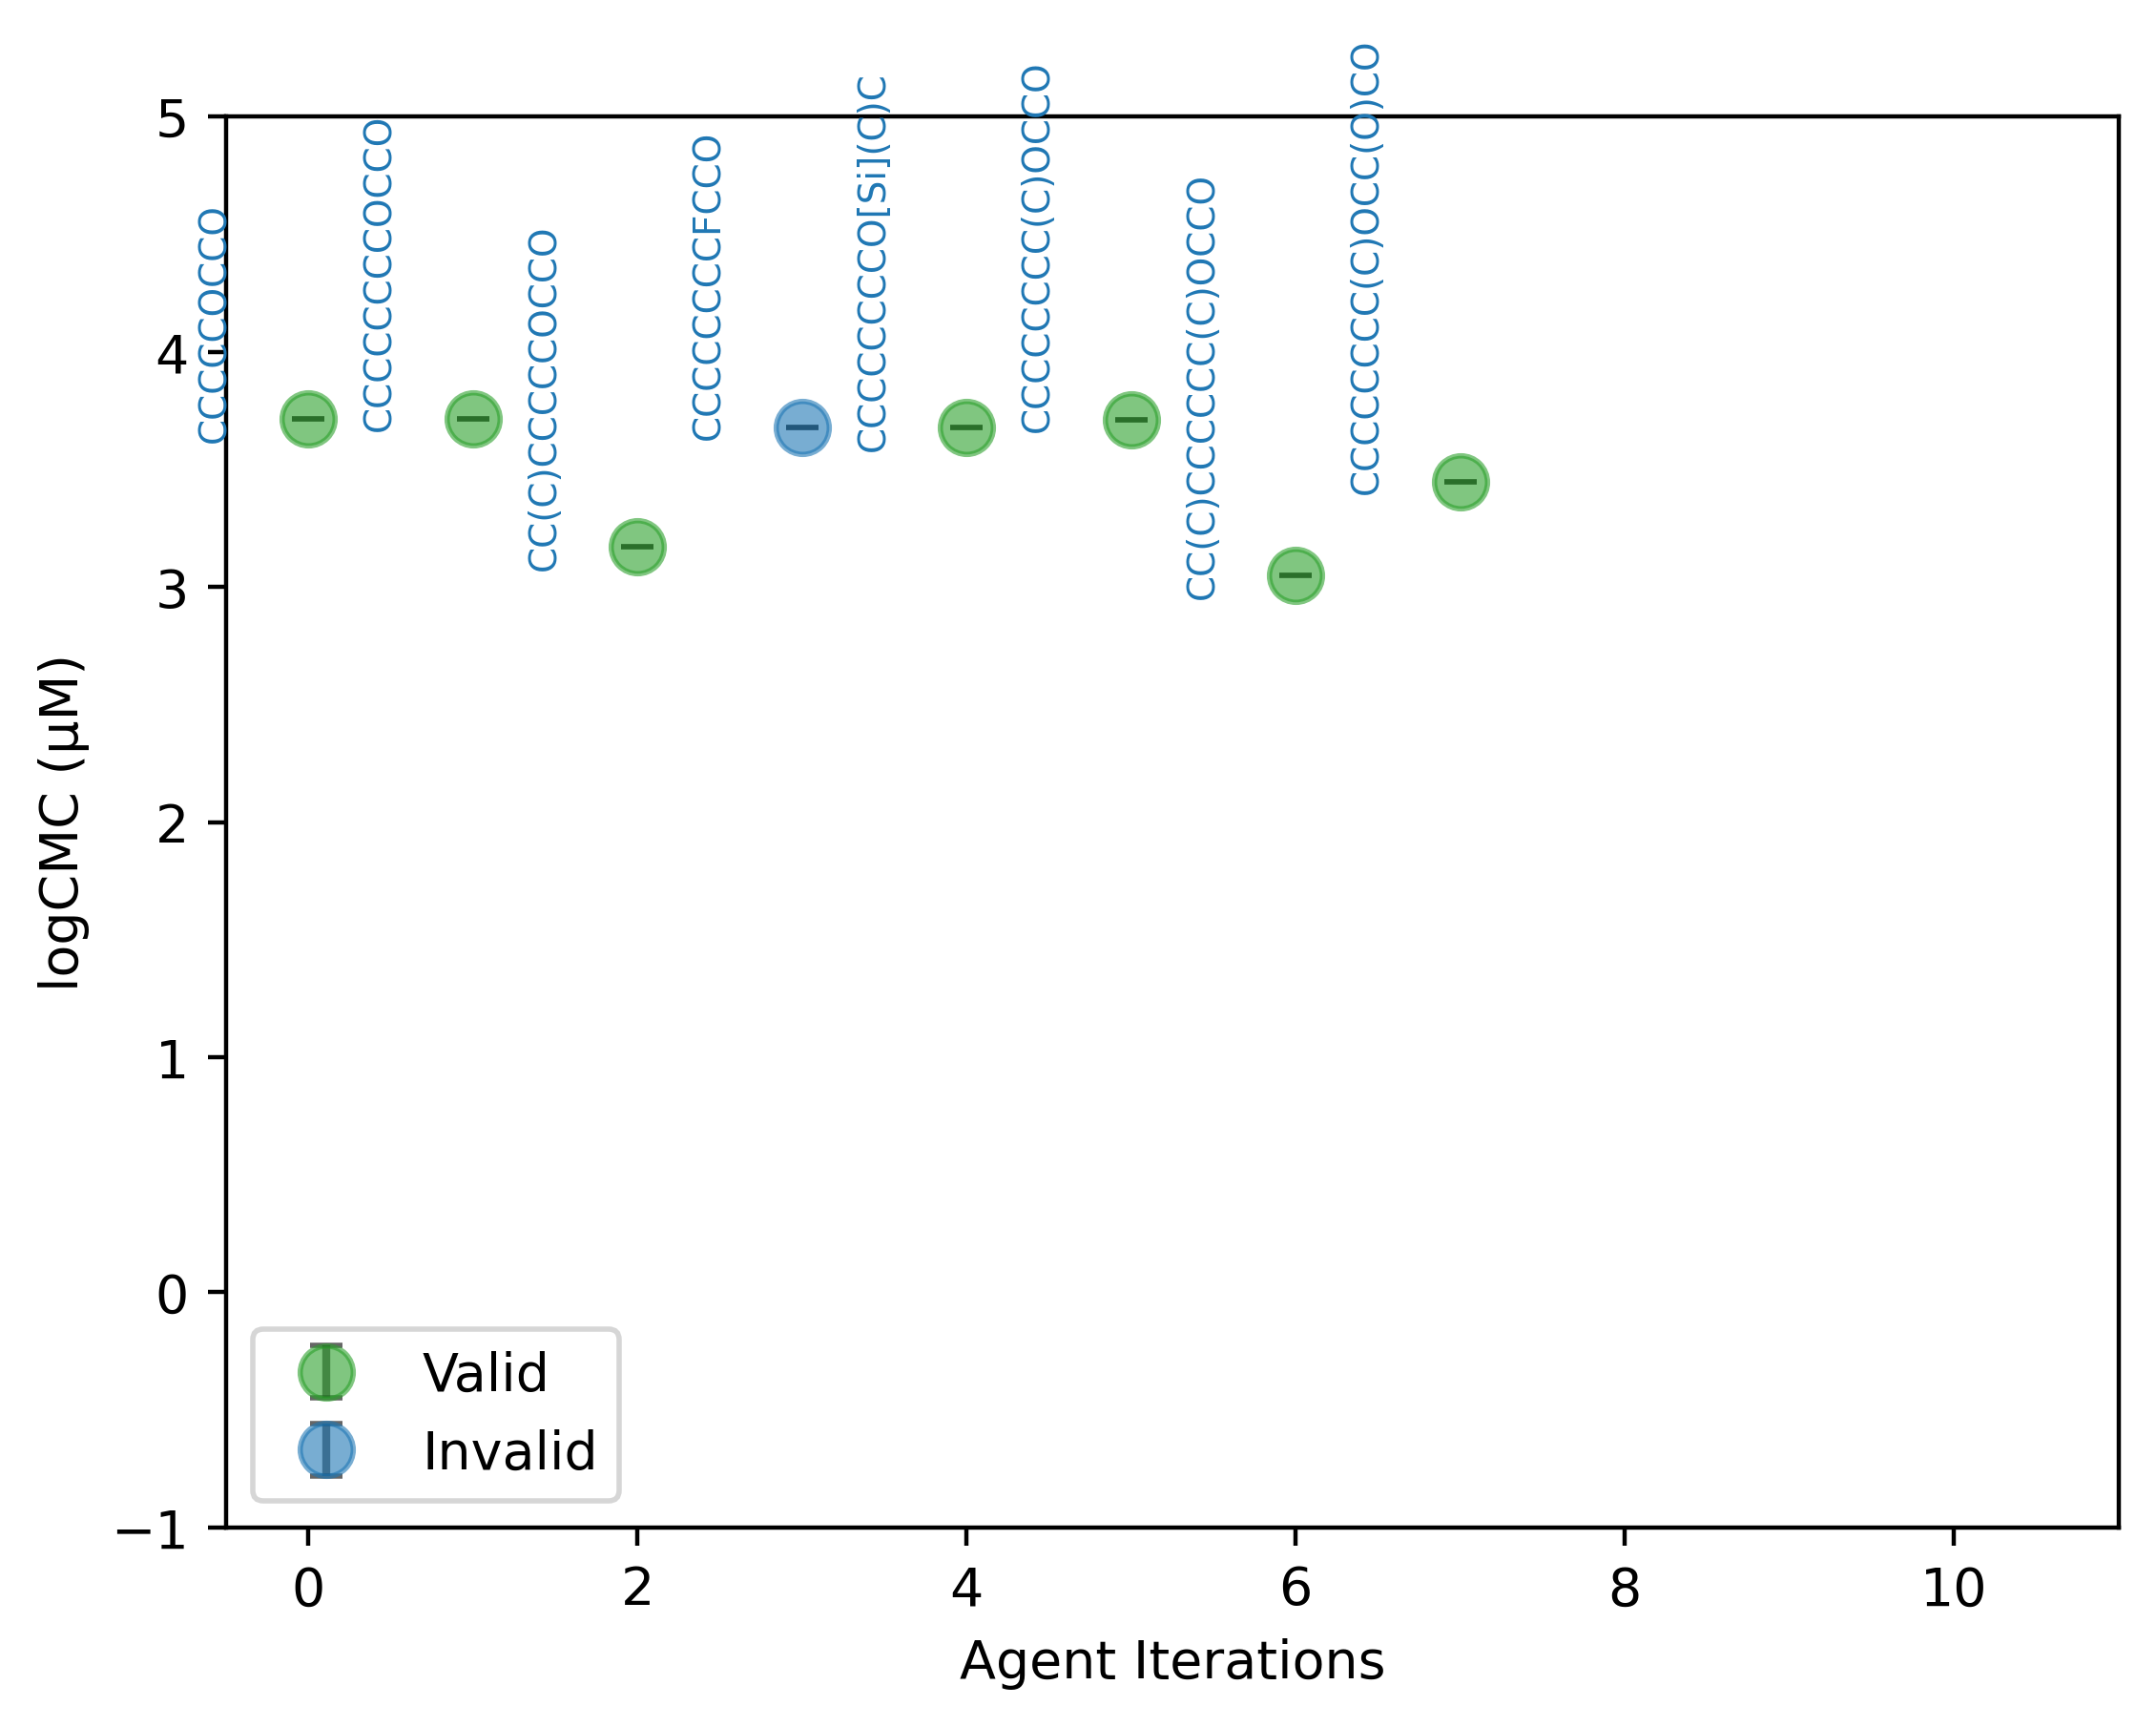

In [26]:
import matplotlib.pyplot as plt

iterations = [item['iteration'] for item in iteration_data]
mean_cmcs = [item['data']['CMC'] for item in iteration_data]
# std_band_gaps = [item['data']['STD CMC'] for item in iteration_data]
smiles_labels = [item['data']['SMILES'] for item in iteration_data]
chemical_feasibilities = [item['data']['Chemical Feasibility'] for item in iteration_data]

plt.figure(dpi=400)

colors = ['C2' if feas == 'Valid' else 'C0' for feas in chemical_feasibilities]

# Plot with error bars and color-coded points
plt.figure(dpi=400)
for i, (x, y, yerr, color) in enumerate(zip(iterations, mean_cmcs, np.zeros(len(mean_cmcs)), colors)):
    plt.errorbar(x, y, yerr=yerr, fmt='o', color=color, ecolor='k', capsize=3,
                 linestyle='None', alpha=0.6, markersize=10, label=chemical_feasibilities[i])



vertical_offsets = [(-10 + 5 * (i % 2)) for i in range(len(iterations))]  # Alternating vertical offsets

for x, y, label, offset in zip(iterations, mean_cmcs, smiles_labels, vertical_offsets):
    plt.text(x-0.2, y + offset/100, label, verticalalignment='bottom', horizontalalignment='right', fontsize=7, color='C0', rotation=90)

ax=plt.gca()
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))

plt.legend(by_label.values(), by_label.keys(), loc="lower left")

plt.xlabel('Agent Iterations')
plt.xlim([-0.5,11])
plt.ylim([-1, 5])
plt.ylabel('logCMC (μM)')

# plt.savefig(f"../results/{iteration_data[0]['data']['SMILES']}_guided.png")

<Figure size 2560x1920 with 0 Axes>

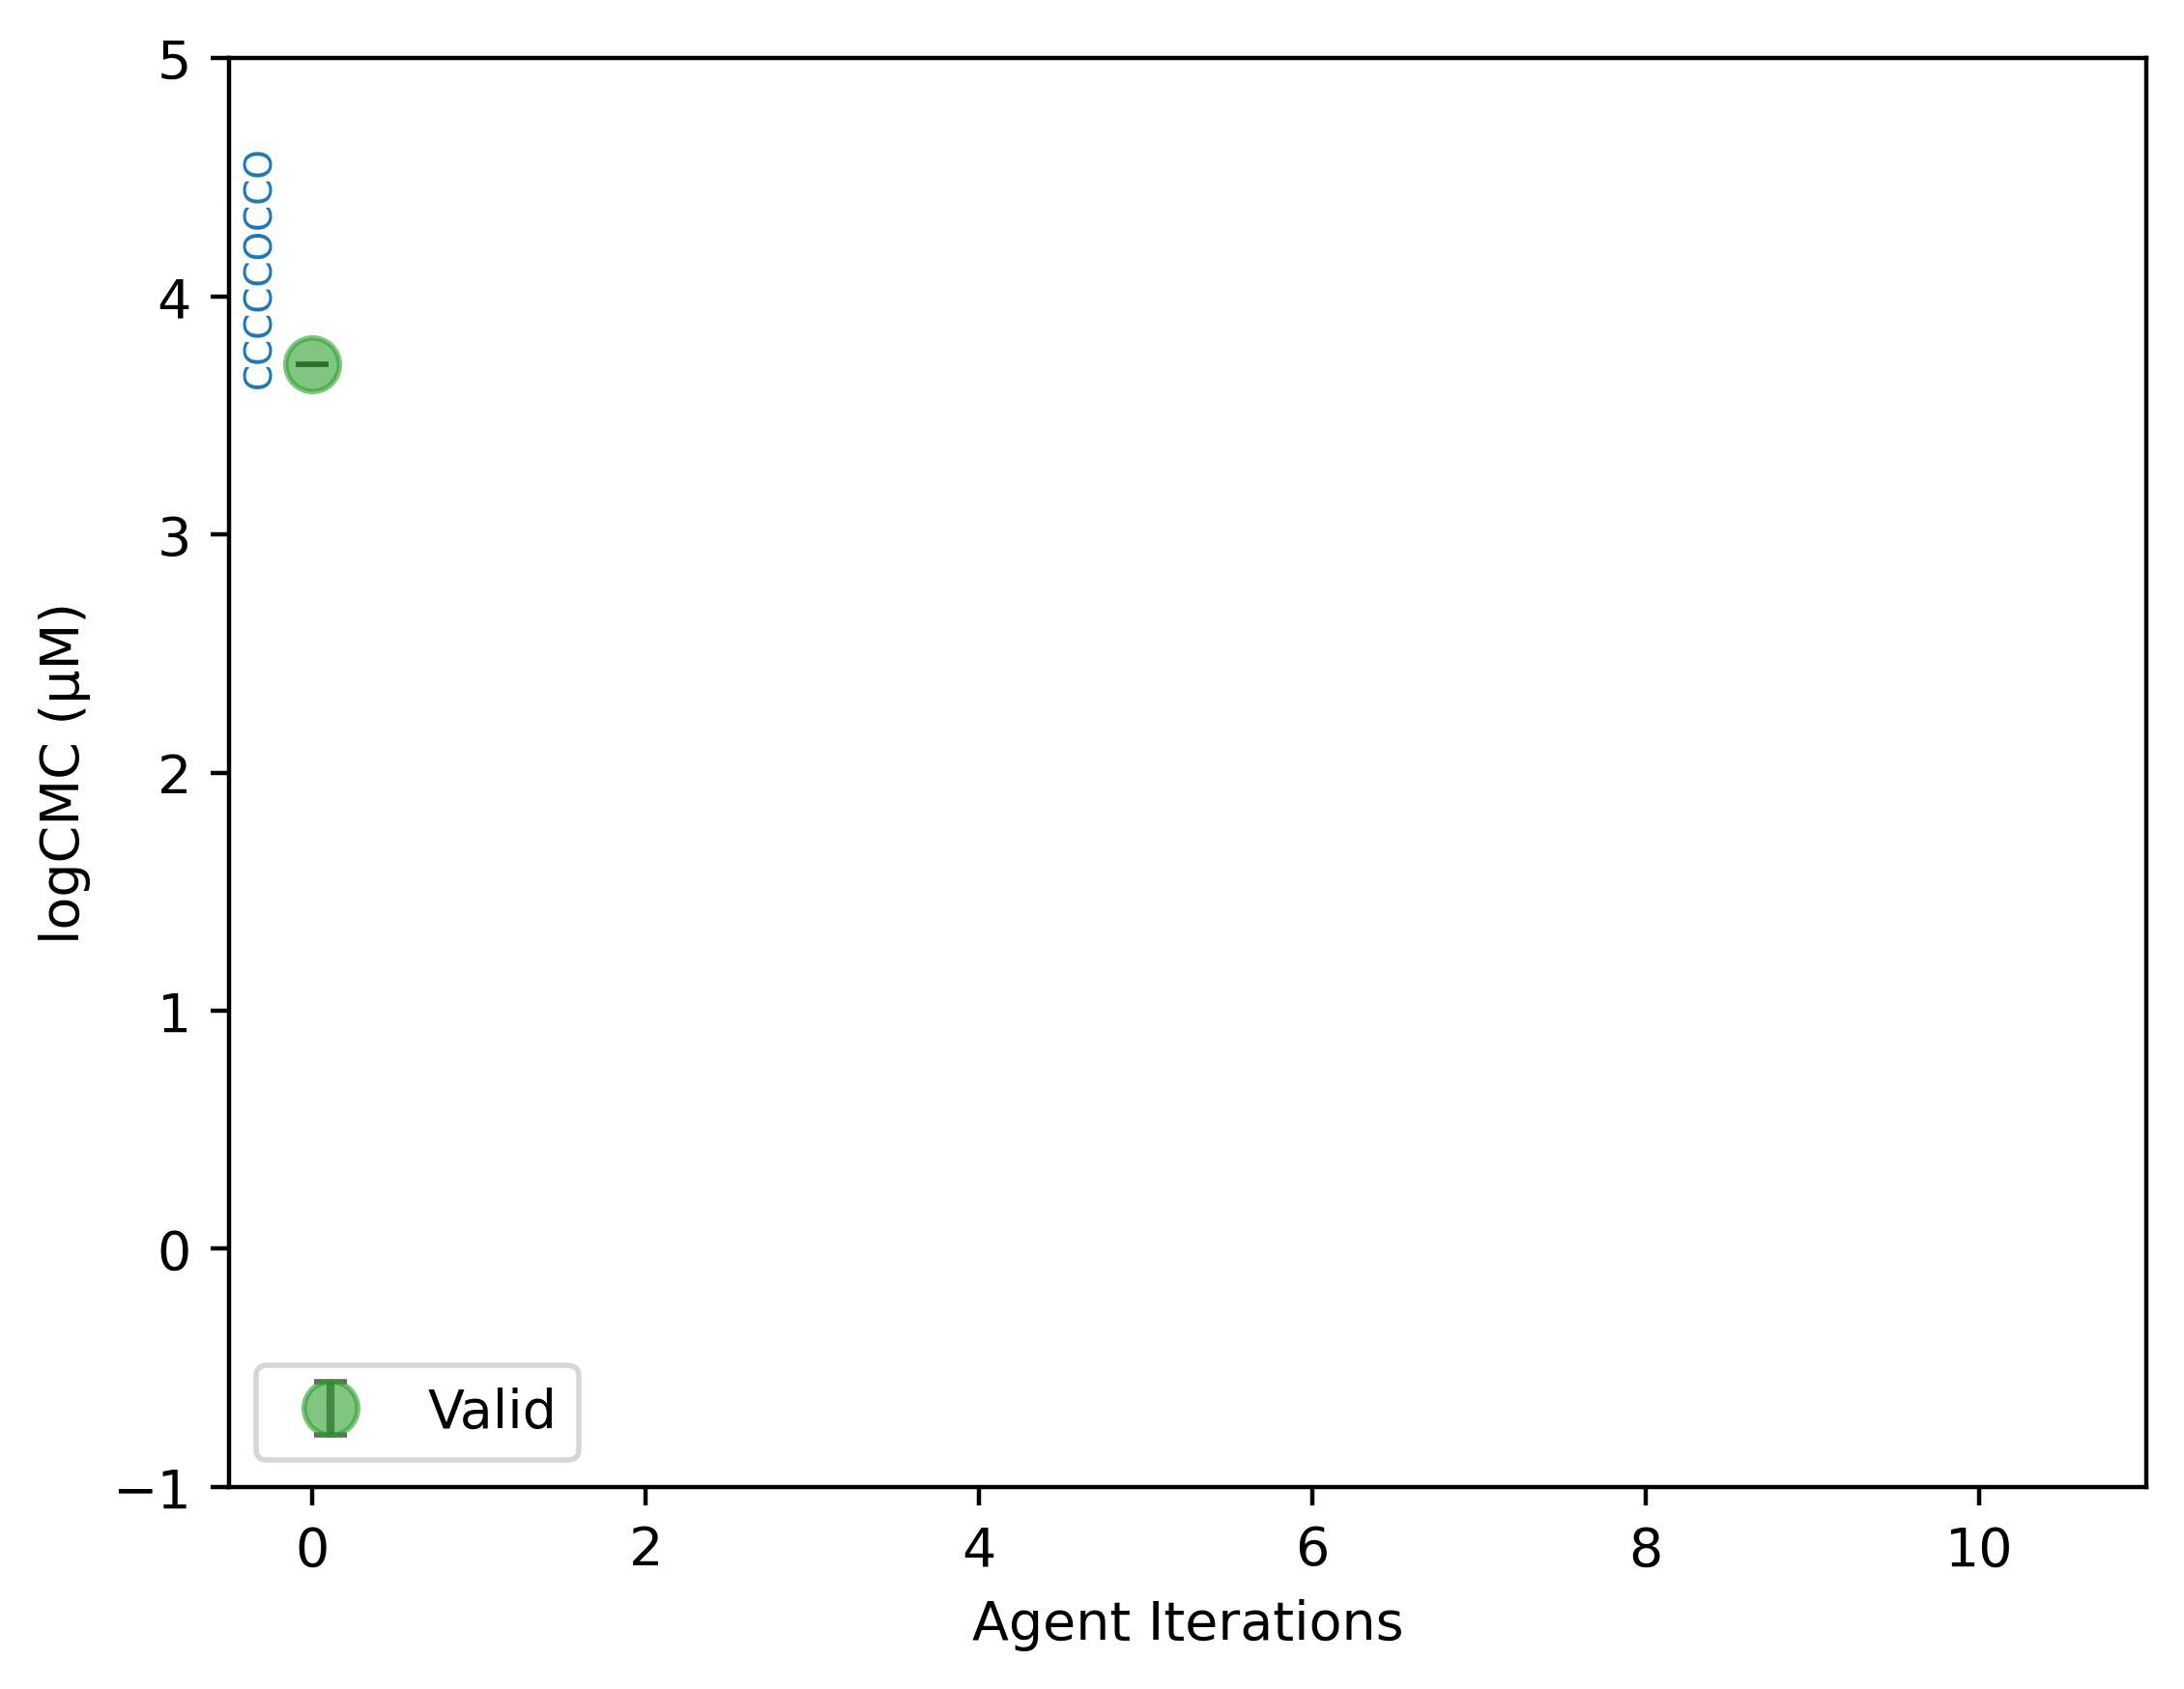

In [13]:
## Plotting sequntially for presentation purposes

from rdkit import Chem
from rdkit.Chem import Draw
import matplotlib.pyplot as plt



from rdkit.Chem import Draw
from PIL import Image

def visualize_smiles(smiles, filename):
    # Convert SMILES to molecule
    mol = Chem.MolFromSmiles(smiles)
    
    # Generate image of the molecule with RDKit and a transparent background
    img = Draw.MolToImage(mol, size=(1000, 1000), kekulize=True, wedgeBonds=True, options=Draw.DrawingOptions())
    
    # Convert the image to have a transparent background
    img = img.convert("RGBA")
    datas = img.getdata()
    newData = []
    for item in datas:
        # Change all white (also shades of whites)
        # to transparent
        if item[0] > 200 and item[1] > 200 and item[2] > 200:
            newData.append((255, 255, 255, 0))
        else:
            newData.append(item)
    img.putdata(newData)
    
    # Save the image
    img.save(filename, "PNG")


import json


with open(f"../results/CMC/{initial_surfactant}_guided.json", "r") as json_file:
    iteration_data = json.load(json_file)

iterations = [item['iteration'] for item in iteration_data]
mean_cmcs = [item['data']['CMC'] for item in iteration_data]
std_cmcs = np.zeros(len(mean_cmcs))
smiles_labels = [item['data']['SMILES'] for item in iteration_data]
chemical_feasibilities = [item['data']['Chemical Feasibility'] for item in iteration_data]

plt.figure(dpi=400)

colors = ['C2' if feas == 'Valid' else 'C0' for feas in chemical_feasibilities]

# Plot with error bars and color-coded points

iter = 0

plt.figure(dpi=400)
for i, (x, y, yerr, color) in enumerate(zip(iterations, mean_cmcs, np.zeros(len(mean_cmcs)), colors)):
    plt.errorbar(x, y, yerr=yerr, fmt='o', color=color, ecolor='k', capsize=3,
                 linestyle='None', alpha=0.6, markersize=10, label=chemical_feasibilities[i])

    filename = f'../results/CMC/iter_{i}_{smiles_labels[i]}.png'
    visualize_smiles(smiles_labels[i], filename)
    if i == iter:
        break


vertical_offsets = [(-10 + 5 * (k % 2)) for k in range(len(iterations))]  # Alternating vertical offsets

for i, (x, y, label, offset) in enumerate(zip(iterations, mean_cmcs, smiles_labels, vertical_offsets)):
    plt.text(x-0.2, y + offset/100, label, verticalalignment='bottom', horizontalalignment='right', fontsize=7, color='C0', rotation=90)
    if i == iter:
        break

ax=plt.gca()
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))

plt.legend(by_label.values(), by_label.keys(), loc="lower left")

plt.xlabel('Agent Iterations')
plt.xlim([-0.5,11])
plt.ylim([-1, 5])
plt.ylabel('logCMC (μM)')

plt.savefig(f"../results/CMC/{iter}_{smiles_labels[iter]}_guided.png")

In [14]:
from rdkit import Chem
from rdkit.Chem import Draw
import matplotlib.pyplot as plt



from rdkit.Chem import Draw
from PIL import Image

def visualize_smiles(smiles, filename):
    # Convert SMILES to molecule
    mol = Chem.MolFromSmiles(smiles)
    
    # Generate image of the molecule with RDKit and a transparent background
    img = Draw.MolToImage(mol, size=(1000, 1000), kekulize=True, wedgeBonds=True, options=Draw.DrawingOptions())
    
    # Convert the image to have a transparent background
    img = img.convert("RGBA")
    datas = img.getdata()
    newData = []
    for item in datas:
        # Change all white (also shades of whites)
        # to transparent
        if item[0] > 200 and item[1] > 200 and item[2] > 200:
            newData.append((255, 255, 255, 0))
        else:
            newData.append(item)
    img.putdata(newData)
    
    # Save the image
    img.save(filename, "PNG")

# Example usage
filename = f'{initial_surfactant}.png'
visualize_smiles(initial_surfactant, filename)

In [15]:
# results = agent.invoke(input=f"Look up design guidelines and make changes to the MOF [Co].[O-]C(=O)c1ccncc1 so it will have a higher band gap:\
#             After each change you should first check validity of new SMILES, if valid evaluate the band gap, otherwise revert change and try something else. Do 5 iterations.\n\
#             ")